# Deep Learning Notebook of project Building-Perceptron

## Introduction (must be done in english)

## Imports

In [2]:
# !pip install --upgrade pip
# !pip install boruta

In [3]:
# run pipreqs --force in notebook for imports outside of

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
import statsmodels.api as sm

# Feature Selection & Importance & VIF
import shap
shap.initjs()
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Preprocessing
from sklearn.model_selection import train_test_split


# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# metrics
from sklearn.metrics import accuracy_score, recall_score
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


2024-11-07 15:12:49.597206: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 15:12:49.598961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 15:12:49.634426: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-07 15:12:49.635893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 15:12:50.356704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

### Custom Imports

In [5]:
from functions import compare_feature_lists

### Sns Styles

In [6]:

orange = "#FFA500"
purple = "#800080"
grey = "#808080"

custom_palette = ["#FFA500", "#FF8C00", "#FF5500", "#FF2200", "#800040", "#400080", "#800080", "#808080", "#808080"]

custom_palette_f5 = [
    purple   ,  # purple
    '#3B528B',  # Blue
    orange   ,  #orange
    '#21918C',  # Green
    # '#5DC863',  # Yellow-Green
    grey     ,  #grey
    # '#FDE725'   # Yellow
]

viridis_colors = [
    purple   ,  # Purple
    '#3B528B',  # Blue
    '#21918C',  # Green
    '#5DC863',  # Yellow-Green
    '#FDE725'   # Yellow
]

sns.set_palette(custom_palette)


## Data Exploration

### Loading Data

In [7]:
original_df = pd.read_csv("data/bcw_data.csv")
# shuffling df to prepare for eventual data reduction from balancing target
df = original_df.sample(frac=1).reset_index(drop=True)


### Exploratory analysis

#### General checks

In [8]:
df.shape

(569, 33)

In [9]:
df.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,857374,B,11.94,18.24,75.71,437.6,0.08261,0.04751,0.01972,0.01349,...,21.33,83.67,527.2,0.1144,0.08906,0.09203,0.06296,0.2785,0.07408,NaN
1,8711003,B,12.25,17.94,78.27,460.3,0.08654,0.06679,0.03885,0.02331,...,25.22,86.60,564.2,0.1217,0.17880,0.19430,0.08211,0.3113,0.08132,NaN


In [10]:
df.duplicated().sum()

0

In [11]:
df.dtypes.value_counts().index

Index([float64, int64, object], dtype='object')

In [12]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [13]:
df.isna().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [14]:
df["Unnamed: 32"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
564   NaN
565   NaN
566   NaN
567   NaN
568   NaN
Name: Unnamed: 32, Length: 569, dtype: float64

In [15]:
df.drop(columns = ["Unnamed: 32"], inplace=True)

In [16]:
percentage_missing = df.isnull().sum().sort_values(ascending = False)/df.shape[0]*100
print(f"{percentage_missing[percentage_missing<30].count()} beneficial features")
percentage_missing

32 beneficial features


id                         0.0
diagnosis                  0.0
symmetry_worst             0.0
concave points_worst       0.0
concavity_worst            0.0
compactness_worst          0.0
smoothness_worst           0.0
area_worst                 0.0
perimeter_worst            0.0
texture_worst              0.0
radius_worst               0.0
fractal_dimension_se       0.0
symmetry_se                0.0
concave points_se          0.0
concavity_se               0.0
compactness_se             0.0
smoothness_se              0.0
area_se                    0.0
perimeter_se               0.0
texture_se                 0.0
radius_se                  0.0
fractal_dimension_mean     0.0
symmetry_mean              0.0
concave points_mean        0.0
concavity_mean             0.0
compactness_mean           0.0
smoothness_mean            0.0
area_mean                  0.0
perimeter_mean             0.0
texture_mean               0.0
radius_mean                0.0
fractal_dimension_worst    0.0
dtype: f

In [17]:
# Get the number of unique values for each column and sort in ascending order
sorted_unique_counts = df.nunique().sort_values(ascending=True)

# Display the result
print(sorted_unique_counts)

diagnosis                    2
smoothness_worst           411
symmetry_mean              432
radius_mean                456
radius_worst               457
smoothness_mean            474
texture_mean               479
concave points_worst       492
symmetry_se                498
fractal_dimension_mean     499
symmetry_worst             500
concave points_se          507
texture_worst              511
perimeter_worst            514
texture_se                 519
perimeter_mean             522
area_se                    528
compactness_worst          529
perimeter_se               533
concavity_se               533
fractal_dimension_worst    535
concavity_mean             537
compactness_mean           537
concavity_worst            539
area_mean                  539
radius_se                  540
compactness_se             541
concave points_mean        542
area_worst                 544
fractal_dimension_se       545
smoothness_se              547
id                         569
dtype: i

#### Objects

In [18]:
df.select_dtypes(include=['object']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   diagnosis  569 non-null    object
dtypes: object(1)
memory usage: 4.6+ KB


In [19]:
df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

#### Int64

In [20]:
df.select_dtypes(include=['int64']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      569 non-null    int64
dtypes: int64(1)
memory usage: 4.6 KB


#### Float64

In [21]:
df.select_dtypes(include=['float64']).info() # object int64 float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   radius_mean              569 non-null    float64
 1   texture_mean             569 non-null    float64
 2   perimeter_mean           569 non-null    float64
 3   area_mean                569 non-null    float64
 4   smoothness_mean          569 non-null    float64
 5   compactness_mean         569 non-null    float64
 6   concavity_mean           569 non-null    float64
 7   concave points_mean      569 non-null    float64
 8   symmetry_mean            569 non-null    float64
 9   fractal_dimension_mean   569 non-null    float64
 10  radius_se                569 non-null    float64
 11  texture_se               569 non-null    float64
 12  perimeter_se             569 non-null    float64
 13  area_se                  569 non-null    float64
 14  smoothness_se            5

#### Univariable analysis

#### Bivariable analysis ( a corriger le nom)

### Data Cleaning

#### Target 

In [22]:
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == "M" else 0)

In [23]:
df.diagnosis.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

##### Balancing the target (Undersampling)

As we don't operate oversampling on medical data, we'll have to undersample the data

In [24]:
df[df.diagnosis == 1].shape[0]

212

In [25]:
# Separate the two classes
class_1 = df[df.diagnosis == 1]
class_0 = df[df.diagnosis == 0]

# Randomly sample class_0 to match the number of samples in class_1
class_0_balanced = class_0.sample(n=class_1.shape[0], random_state=42)  # Set random_state for reproducibility

# Concatenate the balanced classes
balanced_df = pd.concat([class_1, class_0_balanced], ignore_index=True)
print(balanced_df.diagnosis.value_counts())

diagnosis
1    212
0    212
Name: count, dtype: int64


## Isolating changes made for future pipeline

In [26]:
df = original_df.copy()
# classify target, Benign as 0, Malignant as 1
df.diagnosis = df.diagnosis.apply(lambda x: 1 if x == "M" else 0)

# dropping useless cols
df.drop(columns = ["id", "Unnamed: 32"], inplace=True)

In [27]:
# don't forget to do the balancing and every other operations after it again.

## Preparing for Deep Learning

### Feature Selection / Dimensionality Reduction

#### Shap Feature Importance on a basic Random Forest for reference

This is just used as a mean to compare with our feature selection algorythms to identify some values we may have missed out on.

In [28]:
X = df.drop("diagnosis", axis=1) # Independent variables
y = df.diagnosis # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



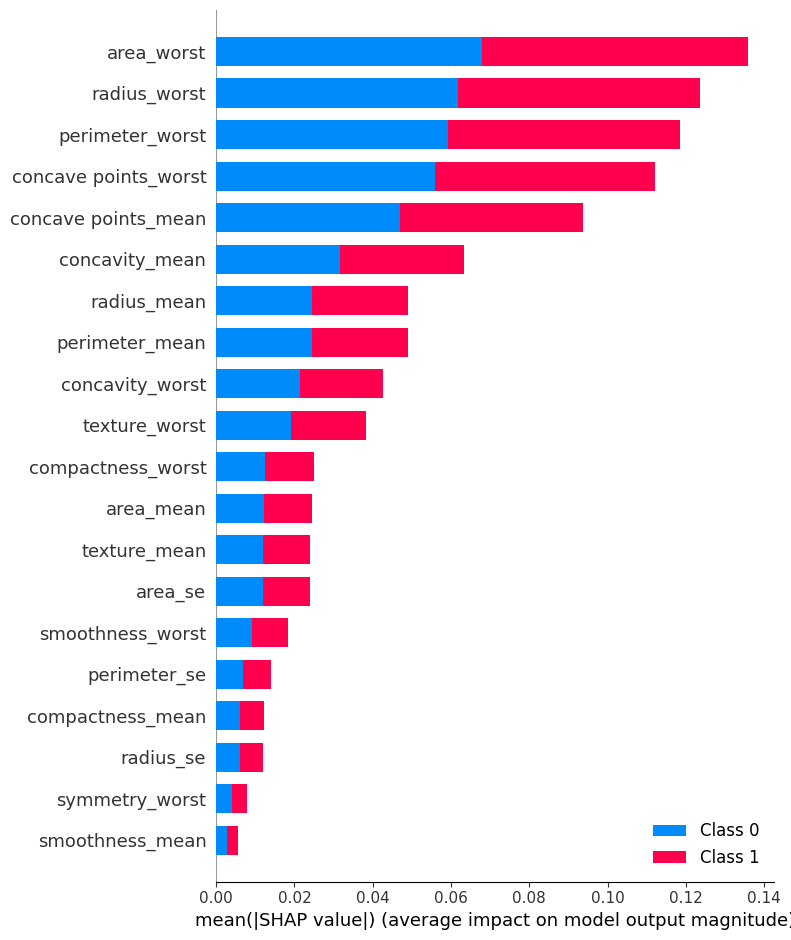

In [29]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

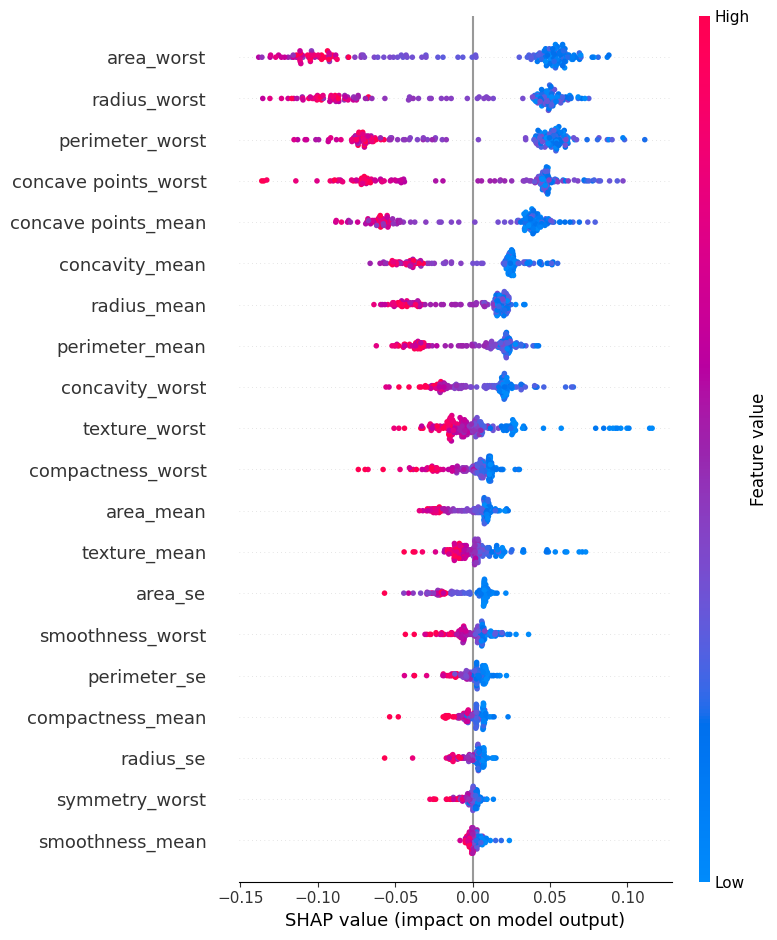

In [30]:
shap.summary_plot(shap_values[0], X_test)

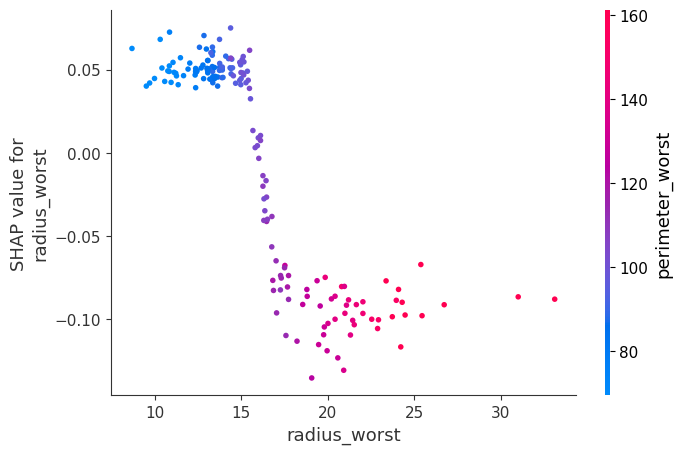

In [31]:
shap.dependence_plot("radius_worst", shap_values[0], X_test,interaction_index="perimeter_worst")

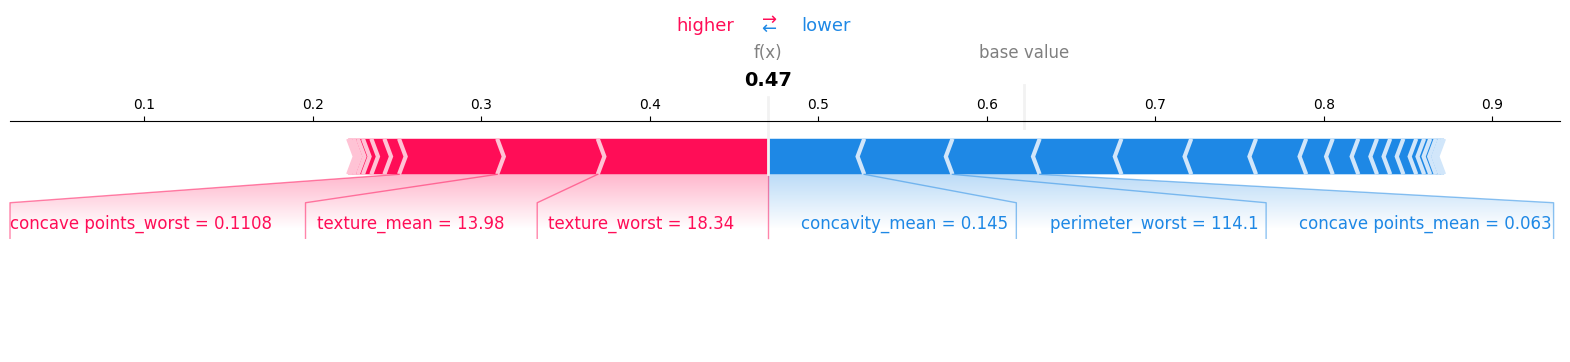

In [32]:
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0, :], matplotlib = True)

In [33]:
# shap.plots.force(explainer.expected_value[1], shap_values[1][6, :], X_test.iloc[6, :],matplotlib = True)

In [34]:
# impact_scores = np.abs(shap_values[1]).sum(axis=1)
# most_impactful_index = np.argmax(impact_scores)  # Gives the index of the most impactful sample
# impact_scores

In [35]:
# Sum of absolute SHAP values across all samples for each feature
feature_impact_scores = np.abs(shap_values[1]).sum(axis=0)

# Creating a dictionary with feature names and their associated impact scores
impact_scores_dict = dict(zip(X_test.columns, feature_impact_scores))

# Sorting the dictionary by values (impact scores) in descending order
sorted_impact_scores_dict = dict(sorted(impact_scores_dict.items(), key=lambda item: item[1], reverse=True))

# Printing the sorted impact scores
print(sorted_impact_scores_dict)


{'area_worst': 11.607696024509172, 'radius_worst': 10.574677725764799, 'perimeter_worst': 10.139493851974136, 'concave points_worst': 9.573872257182103, 'concave points_mean': 8.010506399513124, 'concavity_mean': 5.422408378440909, 'radius_mean': 4.193673529581849, 'perimeter_mean': 4.189383753948095, 'concavity_worst': 3.646461486253767, 'texture_worst': 3.273781751423819, 'compactness_worst': 2.1328610087130326, 'area_mean': 2.095891231209489, 'texture_mean': 2.059712625401608, 'area_se': 2.058448653059262, 'smoothness_worst': 1.577623428583382, 'perimeter_se': 1.1913221244953485, 'compactness_mean': 1.0450382149043835, 'radius_se': 1.0247108771750117, 'symmetry_worst': 0.6749090172737171, 'smoothness_mean': 0.46905635068584234, 'fractal_dimension_worst': 0.4176381281979129, 'symmetry_se': 0.2888055850439763, 'texture_se': 0.26538611898324327, 'smoothness_se': 0.2644274461686081, 'concave points_se': 0.25786168313038876, 'concavity_se': 0.2562314170000396, 'fractal_dimension_mean': 0

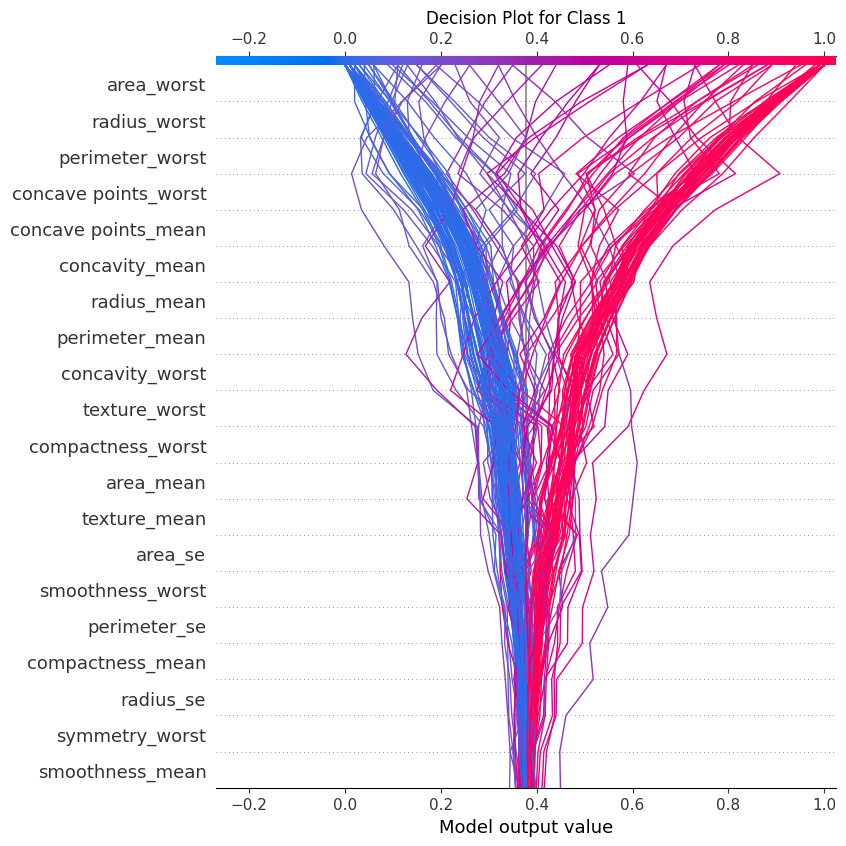

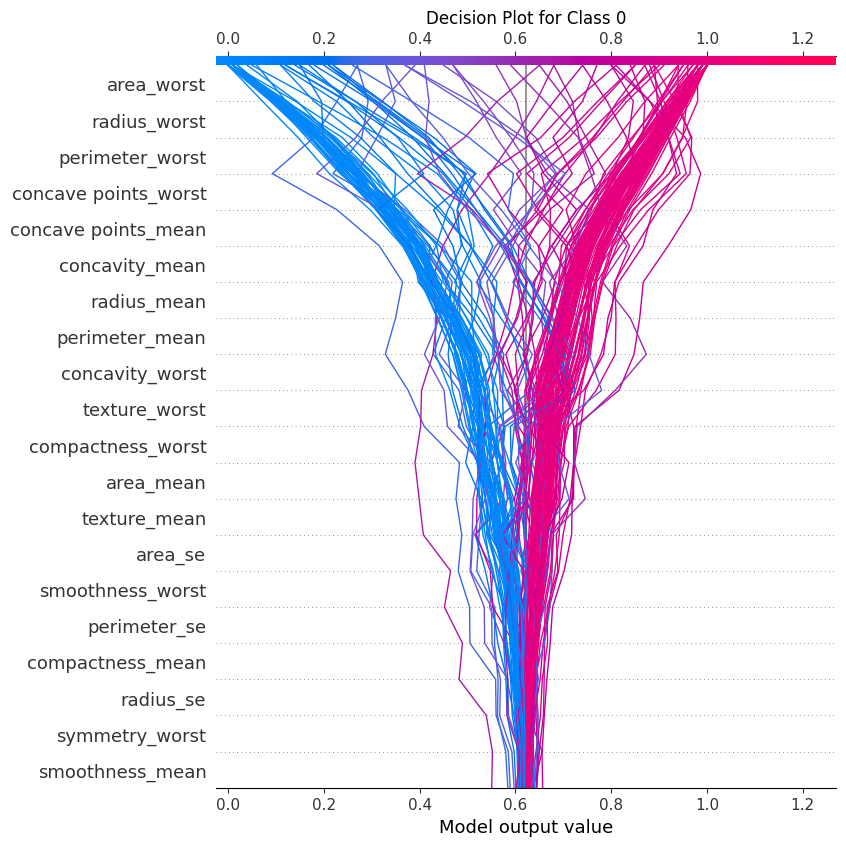

In [36]:
# Decision plot for class 1
plt.title('Decision Plot for Class 1')
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

# Decision plot for class 0
plt.title('Decision Plot for Class 0')
shap.decision_plot(explainer.expected_value[0], shap_values[0], X_test.columns)

plt.show()


#### Boruta

In [37]:
# Boruta is not up to date with the latests versions of numpy so we need to do this to fix the int error
np.int = np.int32
np.float = np.float64
np.bool = np.bool_


# Get the names of the features
features_names = df.drop(columns=['diagnosis']).columns

rf = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_depth=5)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# find all relevant features
feat_selector.fit(df.drop(columns=['diagnosis']).values, df.diagnosis.values)

# check selected features
print(feat_selector.support_)


# check ranking of features
print(feat_selector.ranking_)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	10 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	11 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	12 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	13 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	14 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	15 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
Iteration: 	16 / 100
Confirmed: 	9
Tentative: 	5
Rejected: 	16
I

In [38]:


# Map the boolean array to feature names
boruta_selected_features = features_names[feat_selector.support_]

# Convert to a list (if needed)
boruta_selected_features_list = boruta_selected_features.tolist()
boruta_selected_features_list

['texture_mean',
 'concave points_mean',
 'area_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'concavity_worst',
 'concave points_worst']

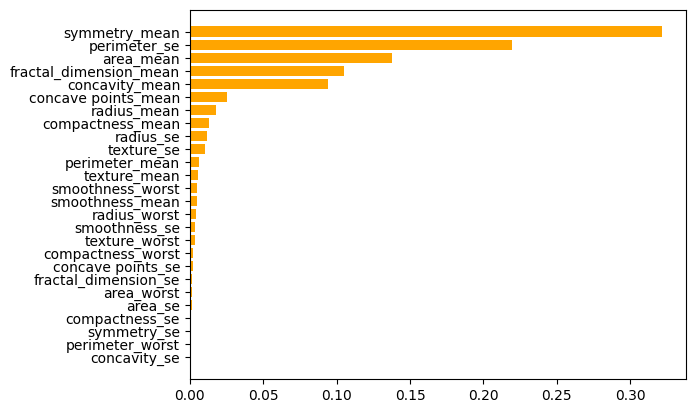

In [39]:
from sklearn.feature_selection import RFECV

f_i = list(zip(features_names,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()


In [40]:
rfe = RFECV(rf,cv=5,scoring="neg_mean_squared_error", verbose=1)

rfe.fit(X_train,y_train)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=5, n_estimators=101, n_jobs=-1,
                                      random_state=RandomState(MT19937) at 0x7FA80A7A6040),
      scoring='neg_mean_squared_error', verbose=1)

In [41]:
rf_selected_features = np.array(features_names)[rfe.get_support()]
rf_selected_features

array(['concave points_mean', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'concave points_worst'],
      dtype=object)

### Preprocessing

#### VIF

In [42]:
features_in_common, unique_features = compare_feature_lists(boruta_selected_features, rf_selected_features)

In [43]:
df[features_in_common]
# Ideally we'll compare it to a version with another deep with values in top 5 of Shap

,texture_worst,radius_worst,area_worst,concave points_worst,perimeter_worst,concave points_mean
0,17.33,25.380,2019.0,0.2654,184.60,0.14710
1,23.41,24.990,1956.0,0.1860,158.80,0.07017
2,25.53,23.570,1709.0,0.2430,152.50,0.12790
3,26.50,14.910,567.7,0.2575,98.87,0.10520
4,16.67,22.540,1575.0,0.1625,152.20,0.10430
...,...,...,...,...,...,...
564,26.40,25.450,2027.0,0.2216,166.10,0.13890
565,38.25,23.690,1731.0,0.1628,155.00,0.09791
566,34.12,18.980,1124.0,0.1418,126.70,0.05302
567,39.42,25.740,1821.0,0.2650,184.60,0.15200


In [44]:
# Split into train and test
X_train_vif, X_test_vif, y_train_vif, y_test_vif = train_test_split(balanced_df[features_in_common], balanced_df.diagnosis,\
    test_size=0.3, random_state=1)


vif_data = pd.DataFrame()
vif_data["feature"] = list(X_train_vif)
vif_data["VIF"] = [variance_inflation_factor(X_train_vif, i)
                          for i in range(len(X_train_vif.columns))]

print('VIF (facteur d\'inflation de la variance)')
print(vif_data)

VIF (facteur d'inflation de la variance)
                feature          VIF
0         texture_worst    23.448620
1          radius_worst  1136.707091
2            area_worst    27.213878
3  concave points_worst    31.691881
4       perimeter_worst  1222.413092
5   concave points_mean    23.292512


### Choosing Metrics

In [45]:
# On va justifier le choix des différentes métriques qu'on va utiliser pour le projet (c'est spécifié plusieurs)

Le ``Recall`` mesure la capacité du modèle à identifier correctement les cas positifs (ici les patients atteint d'une tumeur maligne). Dans un contexte médical, il est essentiel de minimiser les faux négatifs

In [46]:
original_df.diagnosis.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

In [47]:
y.value_counts()

diagnosis
0    357
1    212
Name: count, dtype: int64

<img src="data/img/NPV.webp" style="height:100px" />

## Modelisation

### Importing the ClassPerceptron .py script

In [48]:
# from **** import Laclass

# On peut s'inspirer du test unitaire pour voir le fonctionnement.

### Comparing with a very basic Deep Learning model

could add early stopping

In [49]:
df[features_in_common].dtypes

texture_worst           float64
radius_worst            float64
area_worst              float64
concave points_worst    float64
perimeter_worst         float64
concave points_mean     float64
dtype: object

In [ ]:
X = df[features_in_common] # Independent variables
y = df.diagnosis # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)


# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss for improvement
    patience=15,            # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best performance
)


# Define the model
model = Sequential([
    Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])

# Train the model
history = model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int64")
recall = recall_score(y_test, y_pred)
print("Test Recall:", recall)

Epoch 1/2000


13/13 [==============================] - 1s 14ms/step - loss: 120.5530 - recall: 1.0000 - val_loss: 57.9509 - val_recall: 1.0000
Epoch 2/2000
13/13 [==============================] - 0s 3ms/step - loss: 22.6740 - recall: 0.8311 - val_loss: 19.7303 - val_recall: 0.0000e+00
Epoch 3/2000
13/13 [==============================] - 0s 4ms/step - loss: 12.8189 - recall: 0.2635 - val_loss: 8.9010 - val_recall: 1.0000
Epoch 4/2000
13/13 [==============================] - 0s 4ms/step - loss: 5.1487 - recall: 0.6351 - val_loss: 1.7380 - val_recall: 0.0000e+00
Epoch 5/2000
13/13 [==============================] - 0s 3ms/step - loss: 2.3296 - recall: 0.6824 - val_loss: 2.1562 - val_recall: 0.0000e+00
Epoch 6/2000
13/13 [==============================] - 0s 3ms/step - loss: 1.2380 - recall: 0.5676 - val_loss: 0.4475 - val_recall: 0.8594
Epoch 7/2000
13/13 [==============================] - 0s 3ms/step - loss: 0.6206 - recall: 0.7230 - val_loss: 0.6391 - val_recall: 1.0000
Epoch 8/2000
13/13 [========

NameError: name 'recall_score' is not defined

In [ ]:
y_train

283    1
191    0
356    0
285    0
512    1
      ..
286    0
215    1
211    0
12     1
298    0
Name: diagnosis, Length: 398, dtype: int64

## Evaluating the perceptron model results

## Conclusion

``Concluez sur l’efficacité d’un Perceptron sur ce type de problématique
puis, proposez des solutions sans les implémenter.``

Comme on pouvait s'y attendre, les performances d'un perceptron unique sont ingérieur à celle d'un modèle basique de Machine Learning/Deep Learning, on remarque cependant que vu sa "simplicité"

petit passage comme quoi notre perceptron est nul et c'est en explorant d'autres stratégies comme le backtracking qu'on attendra de très bon résultat